In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../pairedRS')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

(CVXPY) Oct 26 09:45:19 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [23]:
# Some useful functions

def get_scores(n, a=1, b=1, random_state=0):  
    rng = np.random.default_rng(random_state)
    scores = rng.beta(a, b, n)
    return scores


# Bonferroni
def get_bon_qnt(scores, alpha):
    st_scores = np.sort(scores)
    alpha_corrected = alpha / 2
    bon_qnt = np.quantile(st_scores, 1 - alpha_corrected, method="lower")
    return bon_qnt, st_scores


def get_conformal_qnt(scores, alpha, pair_method):
    if pair_method == "indep":
        # pairs are picked at random
        pairs = [[scores[2*i], scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    elif pair_method == "pos_cor":
        # similar scores are grouped
        st_scores = np.sort(scores)
        pairs = [[st_scores[2*i], st_scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
    
    elif pair_method == "neg_cor":
        st_scores = np.sort(scores)
        pairs = [[st_scores[i], st_scores[-(i+1)]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    st_pair_scores = np.sort(pair_scores)
    conformal_qnt = np.quantile(st_pair_scores, 1 - alpha, method="lower")
    return st_pair_scores, conformal_qnt


def plot_st(st_pair_scores, st_scores, conformal_qnt, bon_qnt, n, alpha , x_max=None, y_min=None):
    fig, ax = plt.subplots(1, 3, figsize=(14, 3))
    px = np.arange(1, n//2 + 1) / (n//2)
    h_spacing = bon_qnt/50
    v_spacing = alpha/5
    
    ax[0].plot(st_pair_scores, px)
    ax[0].axhline(y=1-alpha, color='red', linestyle='--')
    ax[0].axvline(x=conformal_qnt, color='blue', linestyle='--')
    ax[0].set_title("Paired scores cdf")
    ax[0].set_xlabel("Paired scores")
    ax[0].set_ylabel("Quantiles")
    ax[0].plot(conformal_qnt, 1-alpha, 'ro')
    ax[0].annotate(f'threshold:{conformal_qnt:.4f}', (conformal_qnt-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[0].annotate(f'quantile:{1-alpha:.2f}', (conformal_qnt-h_spacing, 1-alpha+v_spacing), fontsize=10, color='red', ha='right')
    if x_max is None:
        ax[0].set_xlim(0,  conformal_qnt+5*h_spacing)
    else:
        ax[0].set_xlim(0,  x_max)
        
    x = np.arange(1, n + 1) / n
    ax[1].plot(st_scores, x)
    ax[1].axhline(y=1-alpha/2, color='red', linestyle='--', label='Vertical Line')
    ax[1].axvline(x=bon_qnt, color='blue', linestyle='--')
    ax[1].set_title("Scores cdf")
    ax[1].set_xlabel("Scores")
    ax[1].set_ylabel("Quantiles")
    ax[1].plot(bon_qnt, 1-alpha/2, 'ro')
    ax[1].annotate(f'threshold:{bon_qnt:.4f}', (bon_qnt-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[1].annotate(f'quantile:{1-alpha/2:.2f}', (bon_qnt-h_spacing, 1-alpha/2+v_spacing), fontsize=10, color='red', ha='right')
    if x_max is None:
        ax[1].set_xlim(0,  bon_qnt+5*h_spacing)
    else:
        ax[1].set_xlim(0,  x_max)
        
        
    ax[2].plot(st_pair_scores, px, color='blue', label='Paired')
    ax[2].plot(st_scores, x, color='red', label= 'Unpaired')
    ax[2].axhline(y=1-alpha, color='blue', linestyle='--')
    ax[2].axhline(y=1-alpha/2, color='red', linestyle='--')
    ax[2].set_xlabel("Scores")
    ax[2].set_ylabel("Quantiles")
    if x_max is None:
        ax[2].set_xlim(0,  np.max([bon_qnt+5*h_spacing, conformal_qnt+5*h_spacing]))
    else:
        ax[2].set_xlim(0,  x_max)
    ax[2].legend()
    
    if y_min is None:
        for a in ax:
            a.set_ylim(0.5, 1)
    
    print("Paired quantile is {}, Bonferroni quantile is {}".format(conformal_qnt, bon_qnt))
    print("Interval size ratio (Bonferroni/conformal) is {}".format(bon_qnt/conformal_qnt))

## Weighted model 1
For the model outline and method details, refer to Section 5.3 in the CMC Overleaf draft.
In this setting, we consider $w_1(I_i) = \frac{i}{N}$ where $N$ is the total number of entries in the matrix, and $w_2(I_i)=\frac{1}{n_{\text{test}}}$. Roughly speaking, observations are sampled with a probability proportional to the index value and test points are uniformly sampled from the missing entries.

In [56]:
# Define experiment parameters
n1, n2, r = 100,100,5
prob_obs = 0.5
alpha = 0.1
random_state = 0
model_seed = 2023

In [80]:
# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.5
w = np.arange(1, m*n+1)**scale/(m*n)
w = w/sum(w)

Sampling uniformly from the noiseless random factorization model... 

Dark spots indicating the missing entries.


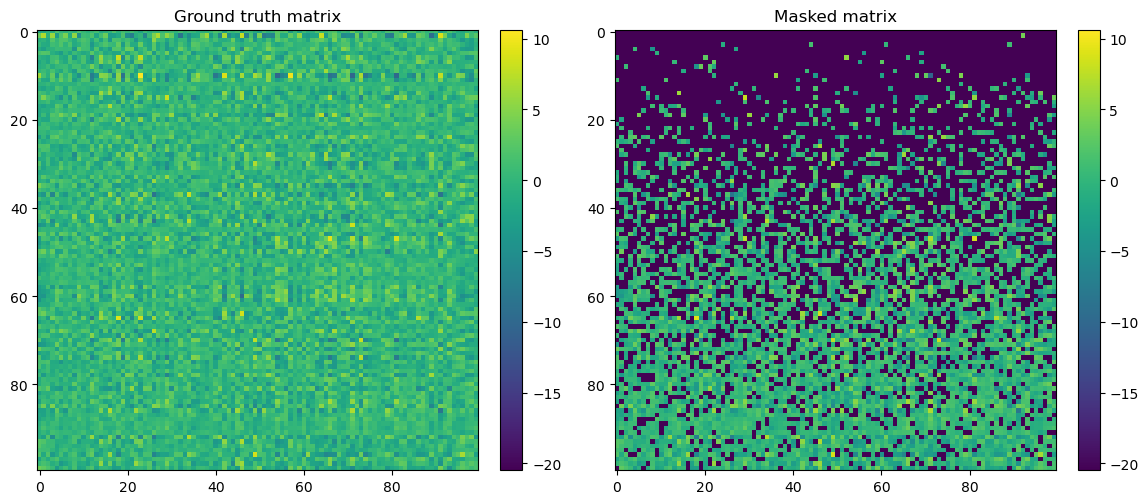

Missing entries are masked in dark color.
Observation size: 5000.0, training size: 2500.0, calib size: 2500.0, calib pairs: 1250


In [81]:
print('Sampling uniformly from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(model_seed)

sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

mask_obs = sampler.sample_submask(obs_size, w=w, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)

vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Missing entries are masked in dark color.")
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [82]:
print("HPM model\n"+"-"*25)
print('Running matrix completion algorithm...')
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state, verbose=False)
#Mhat= svt_solve(M, mask_train, max_iterations=200, random_state=random_state, verbose=False)
print('Done!')

HPM model
-------------------------
Running matrix completion algorithm...
Done!


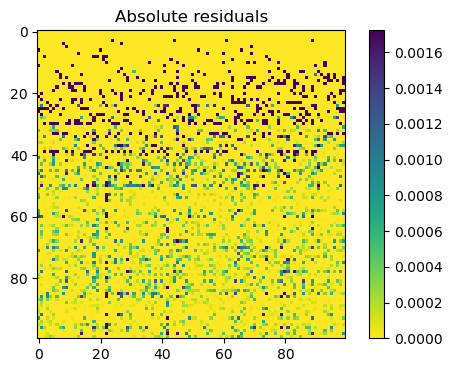

In [83]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [84]:
ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)

In [85]:
st_pair_scores = ci_method.st_calib_scores
conformal_qnt = np.quantile(st_pair_scores, 1 - alpha, method="lower")

scores = np.abs((M-Mhat)[np.where(mask_calib==1)])
bon_qnt, st_scores = get_bon_qnt(scores, alpha)

Paired quantile is 1.4035631681870817, Bonferroni quantile is 1.8978925581401547
Interval size ratio (Bonferroni/conformal) is 1.3521960401622506


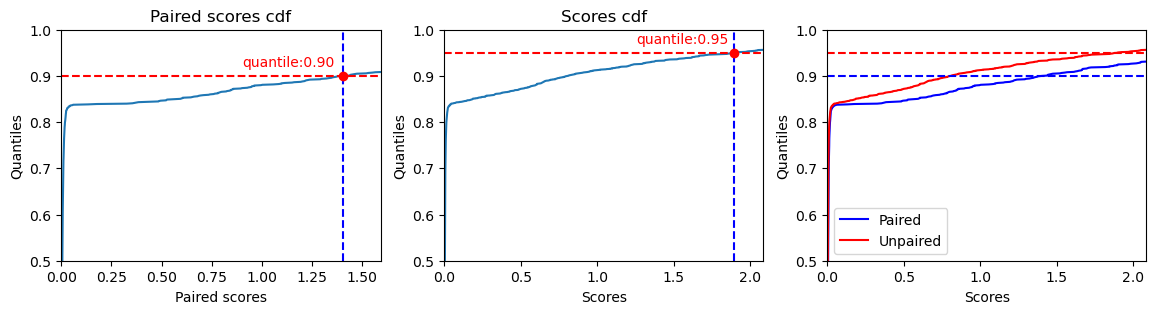

In [86]:
plot_st(st_pair_scores, st_scores, conformal_qnt, bon_qnt, len(st_scores), alpha)

In [53]:
def get_weight(n1, n2, a,b, random_state=0):
    rng = np.random.default_rng(random_state)

    row_w = rng.beta(a,b,n1)
    w = np.transpose(np.tile(row_w, (n2,1)))  
    w /= np.sum(w)
    
    return w

In [87]:
a, b = 1, 100
w = get_weight(n1, n2, a,b, random_state=random_state)

Sampling uniformly from the noiseless random factorization model... 

Dark spots indicating the missing entries.


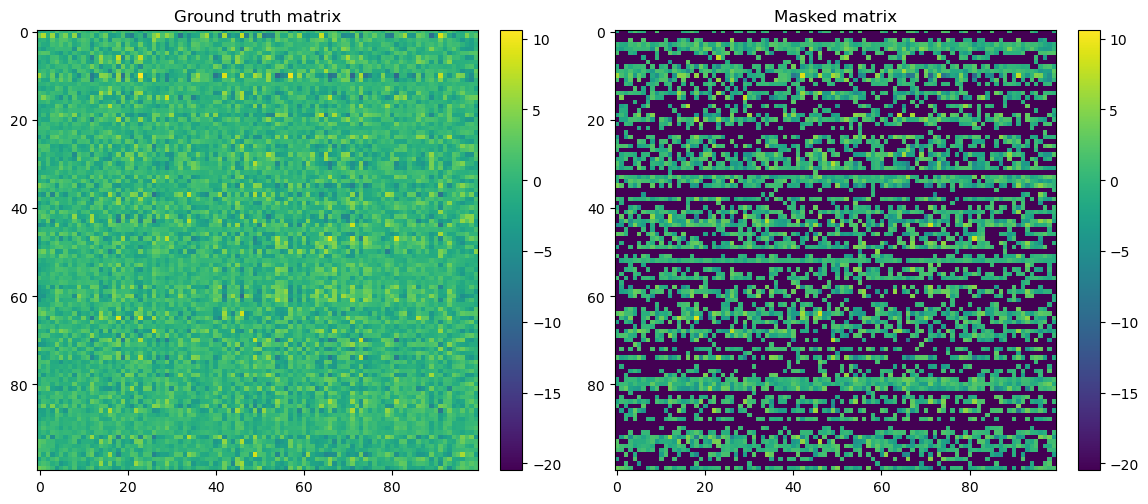

Missing entries are masked in dark color.
Observation size: 5000.0, training size: 2500.0, calib size: 2500.0, calib pairs: 1250


In [89]:
print('Sampling uniformly from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(model_seed)

sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

mask_obs = sampler.sample_submask(obs_size, w=w, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)

vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Missing entries are masked in dark color.")
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [90]:
print("HPM model\n"+"-"*25)
print('Running matrix completion algorithm...')
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state, verbose=False)
#Mhat= svt_solve(M, mask_train, max_iterations=200, random_state=random_state, verbose=False)
print('Done!')

HPM model
-------------------------
Running matrix completion algorithm...
Done!


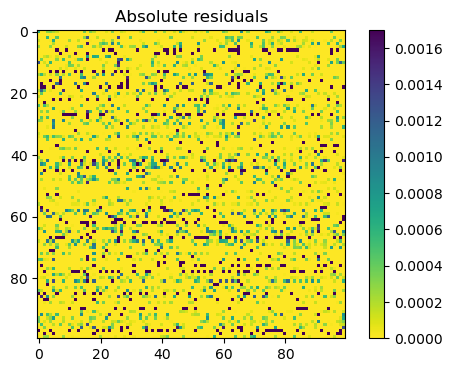

In [91]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

Paired quantile is 1.4147432359133547, Bonferroni quantile is 1.762835852384775
Interval size ratio (Bonferroni/conformal) is 1.2460464963783286


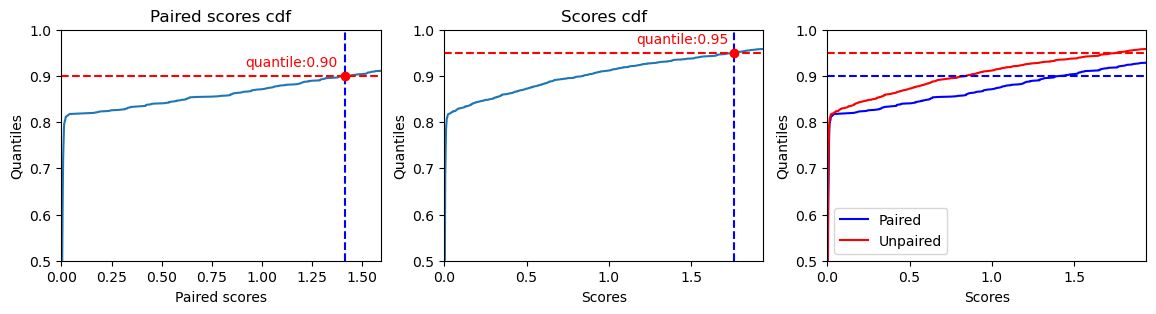

In [92]:
ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)

st_pair_scores = ci_method.st_calib_scores
conformal_qnt = np.quantile(st_pair_scores, 1 - alpha, method="lower")

scores = np.abs((M-Mhat)[np.where(mask_calib==1)])
bon_qnt, st_scores = get_bon_qnt(scores, alpha)

plot_st(st_pair_scores, st_scores, conformal_qnt, bon_qnt, len(st_scores), alpha)